In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d aashita/nyt-comments

kaggle.json
100% 478M/480M [00:04<00:00, 111MB/s] 
100% 480M/480M [00:04<00:00, 105MB/s]


In [3]:
!unzip /content/nyt-comments.zip

Archive:  /content/nyt-comments.zip
  inflating: ArticlesApril2017.csv   
  inflating: ArticlesApril2018.csv   
  inflating: ArticlesFeb2017.csv     
  inflating: ArticlesFeb2018.csv     
  inflating: ArticlesJan2017.csv     
  inflating: ArticlesJan2018.csv     
  inflating: ArticlesMarch2017.csv   
  inflating: ArticlesMarch2018.csv   
  inflating: ArticlesMay2017.csv     
  inflating: CommentsApril2017.csv   
  inflating: CommentsApril2018.csv   
  inflating: CommentsFeb2017.csv     
  inflating: CommentsFeb2018.csv     
  inflating: CommentsJan2017.csv     
  inflating: CommentsJan2018.csv     
  inflating: CommentsMarch2017.csv   
  inflating: CommentsMarch2018.csv   
  inflating: CommentsMay2017.csv     


In [4]:
import pandas as pd
import glob
articles = glob.glob('/content/Articles*.csv')

In [5]:
li = []

for filename in articles:
    df_a = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_a)

articles = pd.concat(li, axis=0, ignore_index=True)

In [6]:
articles.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,5adb8334068401528a2a9f74,1571,By THE EDITORIAL BOARD,article,The Opioid Crisis Foretold,"['Opioids and Opiates', 'Drug Abuse and Traffi...",68,Editorial,10,2018-04-21 18:30:10,Sunday Review,History supplies precedents and lessons for th...,The New York Times,Editorial,https://www.nytimes.com/2018/04/21/opinion/an-...
1,NaN,5adb8331068401528a2a9f70,1221,By PETER FRITSCH and GLENN R. SIMPSON,article,The Business Deals That Could Imperil Trump,['Russian Interference in 2016 US Elections an...,68,OpEd,3,2018-04-21 18:30:06,Sunday Review,Forget Stormy Daniels. The business records su...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
2,NaN,5adb8330068401528a2a9f6f,1465,By CHRISTOPHER A. PREBLE,article,Adapting to American Decline,"['United States International Relations', 'Uni...",68,OpEd,1,2018-04-21 18:30:05,Sunday Review,The United States is losing its influence as i...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
3,NaN,5adb8330068401528a2a9f6d,1097,By FRANK BRUNI,article,The Republicans’ Big Senate Mess,"['United States Politics and Government', 'Ele...",67,OpEd,3,2018-04-21 18:30:04,Sunday Review,"A convict in West Virginia, bondage in Missour...",The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...
4,NaN,5adb8330068401528a2a9f6e,1306,By SHARON LERNER,article,States Are Doing What Scott Pruitt Won’t,"['Water Pollution', 'Hazardous and Toxic Subst...",68,OpEd,2,2018-04-21 18:30:04,Sunday Review,The federal government may ignore the environm...,The New York Times,Op-Ed,https://www.nytimes.com/2018/04/21/opinion/sun...


In [7]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335 entries, 0 to 9334
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   abstract          167 non-null    object
 1   articleID         9335 non-null   object
 2   articleWordCount  9335 non-null   int64 
 3   byline            9335 non-null   object
 4   documentType      9335 non-null   object
 5   headline          9335 non-null   object
 6   keywords          9335 non-null   object
 7   multimedia        9335 non-null   int64 
 8   newDesk           9335 non-null   object
 9   printPage         9335 non-null   int64 
 10  pubDate           9335 non-null   object
 11  sectionName       9335 non-null   object
 12  snippet           9335 non-null   object
 13  source            9335 non-null   object
 14  typeOfMaterial    9335 non-null   object
 15  webURL            9335 non-null   object
dtypes: int64(3), object(13)
memory usage: 1.1+ MB


In [8]:
#Analyzing the data
print(articles['sectionName'].nunique()) 
print(articles['sectionName'].unique())

62
['Sunday Review' 'Unknown' 'Politics' 'Asia Pacific' 'Baseball' 'Mind'
 'Move' 'Golf' 'Eat' 'Live' 'Lesson Plans' 'Television' 'Family'
 'DealBook' "401(k)'s and Similar Plans" 'Retirement' 'Economy' 'Africa'
 'Soccer' 'Pro Basketball' 'Europe' 'Rugby' 'College Basketball'
 'Middle East' 'Pro Football' 'Energy & Environment ' 'Art & Design'
 'Personal Tech' 'College Football' 'Music' 'Media' 'Hockey'
 'Paying for College' 'Olympics' 'Tennis' 'Insider Events' 'Australia'
 'Wine, Beer & Cocktails' 'Opinion | Politics' 'Americas' 'The Daily'
 'Canada' 'Book Review' 'Automobiles' 'Food' 'Dance' 'Art'
 'Opinion | The World' 'Room For Debate' 'Education Life' 'Editorials'
 'Fashion & Beauty' 'Entrepreneurship' 'Entertainment' 'Weddings'
 'Real Estate' 'Neighborhoods' 'Cricket' 'Student Loans' 'Auto Racing'
 'Cycling' 'Learning']


In [9]:
articles['snippet']

0       History supplies precedents and lessons for th...
1       Forget Stormy Daniels. The business records su...
2       The United States is losing its influence as i...
3       A convict in West Virginia, bondage in Missour...
4       The federal government may ignore the environm...
                              ...                        
9330    Several states and cities have ordered employe...
9331    The beginning, middle and end of a picture boo...
9332    The former N.S.A. and C.I.A. chief on Trump, S...
9333    In “Something Wonderful,” Todd S. Purdum analy...
9334    A pair of two-part productions, “Harry Potter ...
Name: snippet, Length: 9335, dtype: object

In [10]:
art = articles[['articleID', 'headline',	'keywords', 'snippet']]

In [11]:
# Importing the pachages I need
import numpy as np
import pandas as pd
from pprint import pprint
from nltk.tokenize import RegexpTokenizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel #LDA model

In [12]:
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

# Enabling logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [13]:
import nltk
from nltk.corpus import stopwords 
import string
nltk.download('stopwords')
nltk.download('punkt')
stop_words_en = stopwords.words("english") 

stop_words_en = stop_words_en + list(string.punctuation)
stop_words_en = stopwords.words("english") 

stop_words_en = stop_words_en + list(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
# Cleaning the dataset
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc = True removes punctuations

data_words = list(sent_to_words(art['snippet']))

print(data_words[:1])

[['history', 'supplies', 'precedents', 'and', 'lessons', 'for', 'the', 'opioid', 'epidemic', 'raging', 'in', 'america', 'today', 'but', 'we', 'seem', 'to', 'have', 'largely', 'forgotten', 'both']]


In [15]:
# Building the bigram and trigram models
bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.phrases.Phrases(bigram[data_words], threshold=100) 

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [16]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Printing a trigram example from the first line
print(trigram_mod[bigram_mod[data_words[0]]])

['history', 'supplies', 'precedents', 'and', 'lessons', 'for', 'the', 'opioid', 'epidemic', 'raging', 'in', 'america', 'today', 'but', 'we', 'seem', 'to', 'have', 'largely', 'forgotten', 'both']


In [17]:
# Defining functions for stopwords, bigrams and trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_en] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts] 

In [18]:
# Splitting the documents into tokens
tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(art['keywords'])):
    art['keywords'][idx] = art['keywords'][idx]
    art['keywords'][idx] = tokenizer.tokenize(str(art['keywords'][idx]) ) # Split into words.

# Removing numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in art['keywords']]

# Removing words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in art['keywords']]

docs = [[word for word in doc if word not in stop_words_en] for doc in art['keywords']]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
nltk.download('wordnet')
# Considering only words that satisfy the prerequisites previously described
lemmatizer = WordNetLemmatizer()
data_lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
# Ensuring that all the stop words and punctuations are deleted
data_words_nostops = remove_stopwords(data_lemmatized)
data_words_nostops

[['opioids',
  'opiates',
  'drug',
  'abuse',
  'traffic',
  'united',
  'states',
  'politics',
  'government',
  'epidemics',
  'acquired',
  'immune',
  'deficiency',
  'syndrome',
  'purdue',
  'pharma'],
 ['russian',
  'interference',
  'us',
  'elections',
  'ties',
  'trump',
  'associates',
  'presidential',
  'election',
  'money',
  'laundering',
  'real',
  'estate',
  'commercial',
  'foreign',
  'corrupt',
  'practices',
  'act',
  'trump',
  'organization',
  'trump',
  'international',
  'hotel',
  'tower',
  'panama',
  'city',
  'panama',
  'trump',
  'soho',
  'manhattan',
  'ny',
  'hotel',
  'cohen',
  'michael',
  'mueller',
  'robert',
  'iii',
  'steele',
  'christopher',
  'trump',
  'donald'],
 ['united',
  'states',
  'international',
  'relations',
  'united',
  'states',
  'defense',
  'military',
  'forces',
  'south',
  'korea'],
 ['united', 'states', 'politics', 'government', 'elections', 'senate'],
 ['water',
  'pollution',
  'hazardous',
  'toxic',
  '

In [21]:
# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [22]:
# Creating Dictionary
id2word = gensim.corpora.Dictionary(data_words_nostops)

In [23]:
# Creating Corpus for my function
texts = data_words_nostops

In [24]:
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
print(texts[0])
print(corpus[0])

['opioids', 'opiates', 'drug', 'abuse', 'traffic', 'united', 'states', 'politics', 'government', 'epidemics', 'acquired', 'immune', 'deficiency', 'syndrome', 'purdue', 'pharma']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]


In [26]:
# Building the function I'm going to use in order to perform the topic model
num_topics = 20
model = gensim.models.LdaModel(corpus=corpus,
                               id2word=id2word,
                               chunksize=100,
                               alpha='auto',
                               eta='auto',
                               num_topics=20)

In [27]:
model.show_topic(0)

[('new', 0.080863416),
 ('elections', 0.07669841),
 ('york', 0.07225587),
 ('us', 0.06373324),
 ('city', 0.054704674),
 ('federal', 0.041416842),
 ('russian', 0.03598029),
 ('interference', 0.035297405),
 ('ties', 0.035297405),
 ('associates', 0.035297405)]

In [28]:
model.show_topic(1)

[('party', 0.17720102),
 ('republican', 0.09981902),
 ('democratic', 0.062012937),
 ('midterm', 0.031386185),
 ('medicine', 0.023718312),
 ('richard', 0.023503926),
 ('jimmy', 0.021556757),
 ('bay', 0.015884517),
 ('paul', 0.012778254),
 ('voting', 0.011763729)]

In [29]:
pprint(model.print_topics())

[(0,
  '0.081*"new" + 0.077*"elections" + 0.072*"york" + 0.064*"us" + 0.055*"city" '
  '+ 0.041*"federal" + 0.036*"russian" + 0.035*"interference" + 0.035*"ties" + '
  '0.035*"associates"'),
 (1,
  '0.177*"party" + 0.100*"republican" + 0.062*"democratic" + 0.031*"midterm" + '
  '0.024*"medicine" + 0.024*"richard" + 0.022*"jimmy" + 0.016*"bay" + '
  '0.013*"paul" + 0.012*"voting"'),
 (2,
  '0.052*"james" + 0.043*"john" + 0.037*"murders" + 0.027*"movie" + '
  '0.027*"attempted" + 0.026*"movies" + 0.019*"travel" + 0.019*"australia" + '
  '0.018*"vacations" + 0.016*"stephen"'),
 (3,
  '0.082*"international" + 0.056*"united" + 0.053*"relations" + 0.052*"states" '
  '+ 0.033*"defense" + 0.029*"trade" + 0.029*"world" + 0.027*"forces" + '
  '0.027*"military" + 0.024*"korea"'),
 (4,
  '0.084*"women" + 0.082*"girls" + 0.029*"sexual" + 0.027*"harassment" + '
  '0.025*"cancer" + 0.019*"america" + 0.017*"running" + 0.016*"marvel" + '
  '0.016*"entertainment" + 0.013*"tests"'),
 (5,
  '0.080*"nation

In [30]:
doc_lda = model[corpus]
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.70908433716559

Coherence Score:  0.4490747073342172


In [31]:
def format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite..."
1,1,0.0,0.5321,"new, elections, york, us, city, federal, russi...","[russian, interference, us, elections, ties, t..."
2,2,3.0,0.8412,"international, united, relations, states, defe...","[united, states, international, relations, uni..."
3,3,9.0,0.6370,"states, united, politics, trump, government, d...","[united, states, politics, government, electio..."
4,4,5.0,0.6943,"national, jr, agency, california, public, assn...","[water, pollution, hazardous, toxic, substance..."
5,5,18.0,0.7678,"george, protests, riots, demonstrations, bush,...","[bush, barbara, bush, george, reagan, nancy, k..."
6,6,13.0,0.8123,"education, civil, blacks, discrimination, race...","[race, ethnicity, blacks, discrimination, whit..."
7,7,12.0,0.4951,"us, rights, crossword, puzzles, state, human, ...","[crossword, puzzles]"
8,8,3.0,0.4213,"international, united, relations, states, defe...","[politics, government, lobbying, lobbyists, at..."
9,9,17.0,0.3686,"china, care, health, protection, tax, act, fac...","[facebook, inc, sri, lanka, demonstrations, pr..."


In [32]:
df_dominant_topic['articleID'] = articles['articleID'].values
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,articleID
0,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74
1,1,0.0,0.5321,"new, elections, york, us, city, federal, russi...","[russian, interference, us, elections, ties, t...",5adb8331068401528a2a9f70
2,2,3.0,0.8412,"international, united, relations, states, defe...","[united, states, international, relations, uni...",5adb8330068401528a2a9f6f
3,3,9.0,0.6370,"states, united, politics, trump, government, d...","[united, states, politics, government, electio...",5adb8330068401528a2a9f6d
4,4,5.0,0.6943,"national, jr, agency, california, public, assn...","[water, pollution, hazardous, toxic, substance...",5adb8330068401528a2a9f6e
...,...,...,...,...,...,...
9330,9330,10.0,0.5444,"immigration, jobs, north, american, labor, emi...","[discrimination, wages, salaries, labor, jobs,...",5ae82c93068401528a2ab969
9331,9331,6.0,0.4054,"inc, books, literature, book, movement, parent...","[friendship, dewdney, anna, writing, writers, ...",5ae82c95068401528a2ab96b
9332,9332,0.0,0.3277,"new, elections, york, us, city, federal, russi...","[classified, information, state, secrets, russ...",5ae82c9d068401528a2ab96d
9333,9333,1.0,0.2861,"party, republican, democratic, midterm, medici...","[books, literature, purdum, todd, theater, ham...",5ae82c9f068401528a2ab96f


In [33]:
import glob
comments = glob.glob('/content/Comments*.csv')

In [34]:
import pandas as pd
li = []

for filename in comments:
    df_c = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df_c)

comments_info = pd.concat(li, axis=0, ignore_index=True)

In [35]:
len(comments_info)

2176364

In [36]:
comments_info.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial
0,1486065741,58927e0495d0e0392607e1b3,1129.0,ANY anti Trump propaganda from Gaga and my TV ...,21332974.0,21332974.0,<br/>,comment,1.486012e+09,1.0,0,0.0,Sports,0.0,NaN,21332974,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486065741,vilonia,68372461.0,"conway, ar",NaN,NaN,News
1,1486055271,58927e0495d0e0392607e1b3,1129.0,"I'll not watch the SB, nor the grammys or osca...",21332861.0,21332861.0,<br/>,comment,1.486011e+09,1.0,0,0.0,Sports,0.0,NaN,21332861,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055271,Joe Schultz,73635333.0,"Hays, KS",NaN,NaN,News
2,1486055240,58927e0495d0e0392607e1b3,1129.0,"NFL's going to do another ""in-your-face, Ameri...",21332686.0,21332686.0,NaN,comment,1.486009e+09,1.0,0,0.0,Sports,0.0,NaN,21332686,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055240,WilliamPenn2,61340508.0,Tacony,NaN,NaN,News
3,1486055221,58927e0495d0e0392607e1b3,1129.0,I'm continually amazed at the ill-placed crede...,21332622.0,21332622.0,<br/>,comment,1.486008e+09,1.0,0,0.0,Sports,0.0,NaN,21332622,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055221,Jeff Palmer,72632699.0,"Shiloh, IL",NaN,NaN,News
4,1486055214,58927e0495d0e0392607e1b3,1129.0,"Personally, I do not want to see any politics ...",21332516.0,21332516.0,<br/>,comment,1.486007e+09,1.0,0,0.0,Sports,0.0,NaN,21332516,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055214,Matt1234,60683284.0,Seattle,NaN,NaN,News


In [37]:
import numpy as np
comments_info['y']= np.where((comments_info['replyCount'] == 0.0), 0, 1)

In [38]:
comments_info.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial,y
0,1486065741,58927e0495d0e0392607e1b3,1129.0,ANY anti Trump propaganda from Gaga and my TV ...,21332974.0,21332974.0,<br/>,comment,1.486012e+09,1.0,0,0.0,Sports,0.0,NaN,21332974,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486065741,vilonia,68372461.0,"conway, ar",NaN,NaN,News,0
1,1486055271,58927e0495d0e0392607e1b3,1129.0,"I'll not watch the SB, nor the grammys or osca...",21332861.0,21332861.0,<br/>,comment,1.486011e+09,1.0,0,0.0,Sports,0.0,NaN,21332861,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055271,Joe Schultz,73635333.0,"Hays, KS",NaN,NaN,News,0
2,1486055240,58927e0495d0e0392607e1b3,1129.0,"NFL's going to do another ""in-your-face, Ameri...",21332686.0,21332686.0,NaN,comment,1.486009e+09,1.0,0,0.0,Sports,0.0,NaN,21332686,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055240,WilliamPenn2,61340508.0,Tacony,NaN,NaN,News,0
3,1486055221,58927e0495d0e0392607e1b3,1129.0,I'm continually amazed at the ill-placed crede...,21332622.0,21332622.0,<br/>,comment,1.486008e+09,1.0,0,0.0,Sports,0.0,NaN,21332622,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055221,Jeff Palmer,72632699.0,"Shiloh, IL",NaN,NaN,News,0
4,1486055214,58927e0495d0e0392607e1b3,1129.0,"Personally, I do not want to see any politics ...",21332516.0,21332516.0,<br/>,comment,1.486007e+09,1.0,0,0.0,Sports,0.0,NaN,21332516,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055214,Matt1234,60683284.0,Seattle,NaN,NaN,News,0


In [39]:
comments = comments_info[['editorsSelection', 'recommendations', 'replyCount', 'inReplyTo', 'y']]
comments.head()

,editorsSelection,recommendations,replyCount,inReplyTo,y
0,0,0.0,0.0,0.0,0
1,0,0.0,0.0,0.0,0
2,0,0.0,0.0,0.0,0
3,0,0.0,0.0,0.0,0
4,0,0.0,0.0,0.0,0


In [40]:
X = comments[[ 'recommendations', 'replyCount', 'inReplyTo']]
y = comments['y']

In [41]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
pred = logreg.predict(X)
print(len(pred))
print(len(X))

2176364
2176364


In [45]:
comments['predicted'] = pred
comments.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,editorsSelection,recommendations,replyCount,inReplyTo,y,predicted
0,0,0.0,0.0,0.0,0,0
1,0,0.0,0.0,0.0,0,0
2,0,0.0,0.0,0.0,0,0
3,0,0.0,0.0,0.0,0,0
4,0,0.0,0.0,0.0,0,0


In [46]:
df = pd.DataFrame(pred)
comments_info['predicted'] = pred
comments_info.head()

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial,y,predicted
0,1486065741,58927e0495d0e0392607e1b3,1129.0,ANY anti Trump propaganda from Gaga and my TV ...,21332974.0,21332974.0,<br/>,comment,1.486012e+09,1.0,0,0.0,Sports,0.0,NaN,21332974,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486065741,vilonia,68372461.0,"conway, ar",NaN,NaN,News,0,0
1,1486055271,58927e0495d0e0392607e1b3,1129.0,"I'll not watch the SB, nor the grammys or osca...",21332861.0,21332861.0,<br/>,comment,1.486011e+09,1.0,0,0.0,Sports,0.0,NaN,21332861,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055271,Joe Schultz,73635333.0,"Hays, KS",NaN,NaN,News,0,0
2,1486055240,58927e0495d0e0392607e1b3,1129.0,"NFL's going to do another ""in-your-face, Ameri...",21332686.0,21332686.0,NaN,comment,1.486009e+09,1.0,0,0.0,Sports,0.0,NaN,21332686,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055240,WilliamPenn2,61340508.0,Tacony,NaN,NaN,News,0,0
3,1486055221,58927e0495d0e0392607e1b3,1129.0,I'm continually amazed at the ill-placed crede...,21332622.0,21332622.0,<br/>,comment,1.486008e+09,1.0,0,0.0,Sports,0.0,NaN,21332622,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055221,Jeff Palmer,72632699.0,"Shiloh, IL",NaN,NaN,News,0,0
4,1486055214,58927e0495d0e0392607e1b3,1129.0,"Personally, I do not want to see any politics ...",21332516.0,21332516.0,<br/>,comment,1.486007e+09,1.0,0,0.0,Sports,0.0,NaN,21332516,https://graphics8.nytimes.com/images/apps/time...,12.0,0.0,NaN,0.0,NaN,Pro Football,0,approved,1.0,0.0,1486055214,Matt1234,60683284.0,Seattle,NaN,NaN,News,0,0


In [47]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.52


In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) # 223703 + 312973 correct predictions

[[224248 312759]
 [  2215 113688]]


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.42      0.59    537007
           1       0.27      0.98      0.42    115903

    accuracy                           0.52    652910
   macro avg       0.63      0.70      0.50    652910
weighted avg       0.86      0.52      0.56    652910



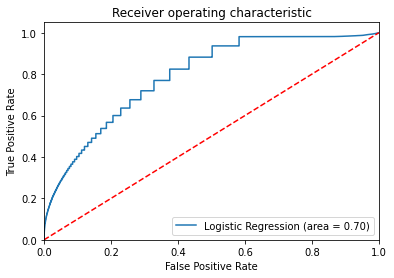

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [51]:
comments_info = comments_info[comments_info.predicted != 0]

In [52]:
comments_info.info() #from 2.176.364 to 1.421.973 (popular) comments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421973 entries, 16 to 2176363
Data columns (total 36 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   approveDate            1421973 non-null  int64  
 1   articleID              1421973 non-null  object 
 2   articleWordCount       1421973 non-null  float64
 3   commentBody            1421973 non-null  object 
 4   commentID              1421973 non-null  float64
 5   commentSequence        1421973 non-null  float64
 6   commentTitle           1379712 non-null  object 
 7   commentType            1421973 non-null  object 
 8   createDate             1421973 non-null  float64
 9   depth                  1421973 non-null  float64
 10  editorsSelection       1421973 non-null  int64  
 11  inReplyTo              1421973 non-null  float64
 12  newDesk                1421973 non-null  object 
 13  parentID               1421973 non-null  float64
 14  parentUserDisplay

In [53]:
inner_join = pd.merge(left=df_dominant_topic, right=comments_info, left_on='articleID', right_on='articleID')

In [54]:
inner_join

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,articleID,approveDate,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial,y,predicted
0,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74,1524428703,1571.0,Thank you for a well-balanced presentation of ...,26831654.0,26831654.0,<br/>,comment,1.524420e+09,1.0,0,0.0,Editorial,0.0,NaN,26831654,http://graphics8.nytimes.com/images/apps/times...,10.0,8.0,NaN,0.0,NaN,Sunday Review,0,approved,1.0,0.0,1524428703,serenity,690130.0,california,NaN,NaN,Editorial,0,1
1,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74,1524428676,1571.0,Fight amongst yourselves. Excuse me while inje...,26831251.0,26831251.0,<br/>,comment,1.524416e+09,1.0,0,0.0,Editorial,0.0,NaN,26831251,http://graphics8.nytimes.com/images/apps/times...,10.0,1.0,NaN,0.0,NaN,Sunday Review,0,approved,1.0,0.0,1524428676,Jean,67292551.0,Los Angeles,NaN,NaN,Editorial,0,1
2,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74,1524427057,1571.0,During AIDS crisis no plans of mass quarantine...,26831451.0,26831451.0,<br/>,comment,1.524418e+09,1.0,0,0.0,Editorial,0.0,NaN,26831451,http://graphics8.nytimes.com/images/apps/times...,10.0,8.0,NaN,0.0,NaN,Sunday Review,0,approved,1.0,0.0,1524427057,Bulgakov's Cat,67115499.0,"Bean fields to the left, corn to the right",NaN,NaN,Editorial,0,1
3,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74,1524424759,1571.0,"We've had a ""drug problem"" in the Untied State...",26831724.0,26831724.0,<br/>,comment,1.524420e+09,1.0,0,0.0,Editorial,0.0,NaN,26831724,http://graphics8.nytimes.com/images/apps/times...,10.0,6.0,NaN,0.0,NaN,Sunday Review,0,approved,1.0,0.0,1524424759,Trina,42660931.0,Indiana,NaN,NaN,Editorial,0,1
4,0,16.0,0.6632,"france, queens, restaurant, abuse, restaurants...","[opioids, opiates, drug, abuse, traffic, unite...",5adb8334068401528a2a9f74,1524423091,1571.0,The NYT editors begin with some very important...,26831320.0,26831320.0,<br/>,comment,1.524417e+09,1.0,0,0.0,Editorial,0.0,NaN,26831320,https://s3.amazonaws.com/pimage.timespeople.ny...,10.0,8.0,NaN,0.0,NaN,Sunday Review,0,approved,1.0,0.0,1524423091,Wherever Hugo,58937383.0,"There, UR",NaN,NaN,Editorial,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418721,9334,8.0,0.4903,"theater, play, league, co, soccer, sports, moo...","[theater, tony, awards, theater, awards, ameri...",5ae82ca3068401528a2ab97a,1525188962,2055.0,"Kiddie books, characters, cartoon idiocy. Poo...",26931540.0,26931540.0,<br/>,comment,1.525181e+09,1.0,0,0.0,Culture,0.0,NaN,26931540,http://graphics8.nytimes.com/images/apps/times...,0.0,19.0,NaN,0.0,NaN,Unknown,0,approved,1.0,0.0,1525188962,Betsy Herring,59790721.0,"Edmond, OK",NaN,NaN,News,0,1
1418722,9334,8.0,0.4903,"theater, play, league, co, soccer, sports, moo...","[theater, tony, awards, theater, awards, ameri...",5ae82ca3068401528a2ab97a,1525188339,2055.0,"so, this is Broadway now?...SpongeBob, Frozen,...",26931921.0,26931921.0,<br/>,comment,1.525182e+09,1.0,0,0.0,Culture,0.0,NaN,26931921,http://graphics8.nytimes.com/images/apps/times...,0.0,25.0,NaN,0.0,NaN,Unknown,0,approved,1.0,0.0,1525188339,Jim,57128966.0,NH,NaN,NaN,News,0,1
1418723,9334,8.0,0.4903,"theater, play, league, co, soccer, sports, m

In [55]:
comments_per_topic = inner_join.groupby('Dominant_Topic').sum('predicted')[['predicted']]

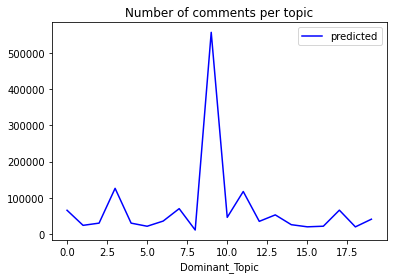

In [56]:
comments_per_topic.plot(color='blue', title='Number of comments per topic')

In [57]:
#topic 7 and 12 have the highest number of comments (310.390 and 479.387). 
#That may be a good indicator of controversy since controversy depends on how much people talks about it and whether there are 
#conflicting opinions

In [58]:
d = []
for i in inner_join['Dominant_Topic'].unique():
  df = [x for x, e in enumerate(inner_join['Dominant_Topic'].squeeze()) if e == i]
  d.append(df)

In [59]:
def remove_stopwords(texts):
    return [[word.lower() for word in simple_preprocess(str(doc)) if word not in stop_words_en] for doc in texts]

In [60]:
cleaned_comments = remove_stopwords(inner_join['commentBody'])

In [61]:
from textblob import TextBlob

In [62]:
##
blob_4=[]
for i in d[4]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_4.append(blob)
sentiment4=[]
for sent in blob_4:
  sentiment4.append(sent.sentiment.polarity)

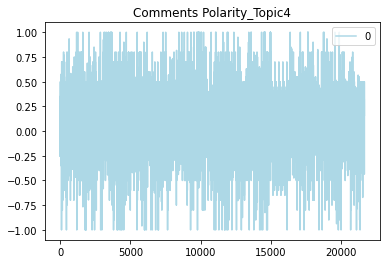

In [63]:
df4 = pd.DataFrame(sentiment4)
df4.plot(color='lightblue', title='Comments Polarity_Topic4')

In [64]:
model.show_topic(4)

[('women', 0.08388186),
 ('girls', 0.08190747),
 ('sexual', 0.028755797),
 ('harassment', 0.02693151),
 ('cancer', 0.02495845),
 ('america', 0.01907517),
 ('running', 0.017223697),
 ('marvel', 0.016207071),
 ('entertainment', 0.015855182),
 ('tests', 0.013315449)]

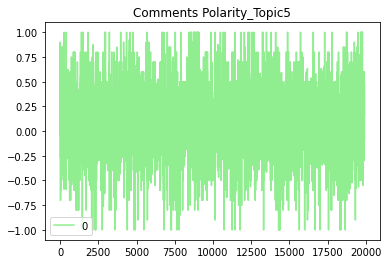

In [65]:
##a lot of comments
blob_5=[]
for i in d[5]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_5.append(blob)
sentiment5=[]
for sent in blob_5:
  sentiment5.append(sent.sentiment.polarity)
df5 = pd.DataFrame(sentiment5)
df5.plot(color='lightgreen', title='Comments Polarity_Topic5')

In [66]:
model.show_topic(5)

[('national', 0.08036911),
 ('jr', 0.05966844),
 ('agency', 0.03741696),
 ('california', 0.036282685),
 ('public', 0.027144715),
 ('assn', 0.02648982),
 ('marketing', 0.025875991),
 ('environmental', 0.025207205),
 ('veterans', 0.020700624),
 ('football', 0.020452458)]

In [67]:
blob_6=[]
for i in d[6]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_6.append(blob)
sentiment6=[]
for sent in blob_6:
  sentiment6.append(sent.sentiment.polarity)

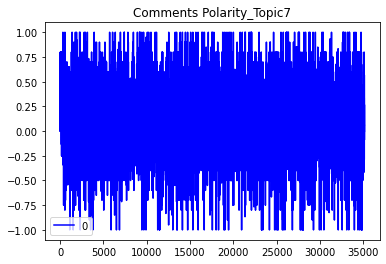

In [68]:
##
blob_7=[]
for i in d[7]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_7.append(blob)
sentiment7=[]
for sent in blob_7:
  sentiment7.append(sent.sentiment.polarity)
df7 = pd.DataFrame(sentiment7)
df7.plot(color='blue', title='Comments Polarity_Topic7')

In [69]:
model.show_topic(7)

[('tv', 0.05524425),
 ('program', 0.055141803),
 ('television', 0.037731774),
 ('syria', 0.029366039),
 ('crimes', 0.025595834),
 ('childhood', 0.020304948),
 ('sex', 0.019029494),
 ('children', 0.018494066),
 ('life', 0.018055705),
 ('family', 0.017626802)]

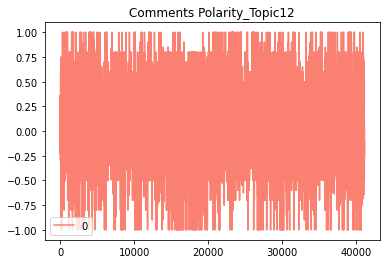

In [70]:
##
blob_12=[]
for i in d[12]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_12.append(blob)
sentiment12=[]
for sent in blob_12:
  sentiment12.append(sent.sentiment.polarity)
df12 = pd.DataFrame(sentiment12)
df12.plot(color='salmon', title='Comments Polarity_Topic12')

In [71]:
model.show_topic(12)

[('us', 0.099389225),
 ('rights', 0.07402859),
 ('crossword', 0.06971794),
 ('puzzles', 0.067262),
 ('state', 0.06021803),
 ('human', 0.046554524),
 ('scott', 0.024394546),
 ('court', 0.023989566),
 ('changes', 0.023060372),
 ('appointments', 0.023060372)]

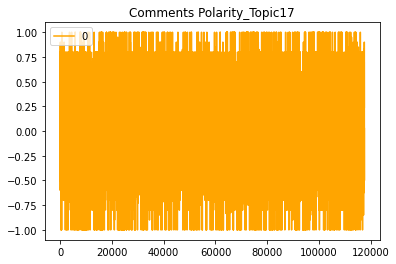

In [72]:
##
blob_17=[]
for i in d[17]:
  blob = TextBlob(str(cleaned_comments[i]))
  blob_17.append(blob)
sentiment17=[]
for sent in blob_17:
  sentiment17.append(sent.sentiment.polarity)
df17 = pd.DataFrame(sentiment17)
df17.plot(color='orange', title='Comments Polarity_Topic17')

In [73]:
model.show_topic(17)

[('china', 0.058969066),
 ('care', 0.054487724),
 ('health', 0.05172128),
 ('protection', 0.051035516),
 ('tax', 0.03881741),
 ('act', 0.036053713),
 ('facebook', 0.0342976),
 ('insurance', 0.0334636),
 ('managed', 0.028476784),
 ('west', 0.026682522)]